# Fitting a Line to Data

The [_Getting started_ tutorial](./getting-started.ipynb) shows how to sample a 3D gaussian with `simpple`.
In this tutorial, we will build on this to demonstrate a more realistic scenario where we fit a line to data.

## Simulated data

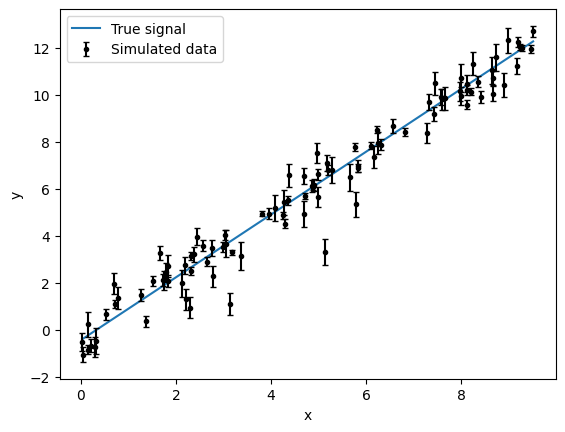

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import loguniform

rng = np.random.default_rng(123)

x = np.sort(10 * rng.random(100))
m_true = 1.338
b_true = -0.45
truths = {"m": m_true, "b": b_true, "sigma": None}
y_true = m_true * x + b_true
yerr = 0.1 + 0.5 * rng.random(x.size)
y = y_true + 2 * yerr * rng.normal(size=x.size)

ax = plt.gca()
ax.plot(x, y_true, label="True signal")
ax.errorbar(x, y, yerr=yerr, fmt="k.", capsize=2, label="Simulated data")
ax.set_ylabel("y")
ax.set_xlabel("x")
plt.legend()
plt.show()

## Linear model

To define our linear model with `simpple`, we could direclty write the log-likelihood function and calculate the model inside of it.
A slightly more granular approach is to first define our "forward model" function and then call that function from the log-likelihood.
Notice that we add an extra parameter to inflate the uncertainties in the likelihood.

In [2]:
def linear_model(p, x):
    return p["m"] * x + p["b"]


def log_likelihood(p, x, y, yerr):
    ymod = linear_model(p, x)
    var = yerr**2 + p["sigma"] ** 2
    return -0.5 * np.sum(np.log(2 * np.pi * var) + (y - ymod) ** 2 / var)

`simpple` has a dedicated class for models that consist of a forward model called in the likelihood: `simpple.model.ForwardModel`.
Using this class instead of the base `Model` has two main advantages: we can sample predictions from the prior with `get_prior_pred()`
and the forward model, accessible through `ForwardModel.forward()` is wrapped to accept either a dictionary or an array.
Let us define such a model. We will use uniform priors on the linear parameters and a log-uniform on `sigma`.

In [3]:
from scipy.stats import uniform

from simpple.distributions import ScipyDistribution
from simpple.model import ForwardModel

parameters = {
    "m": ScipyDistribution(uniform(-10, 20)),
    "b": ScipyDistribution(uniform(-10, 20)),
    "sigma": ScipyDistribution(loguniform(1e-5, 100)),
}

model = ForwardModel(parameters, log_likelihood, linear_model)

First, we can check that the model works as expected on a single test point.
Note that all arguments required by the likelihood are also required by the log-posterior (`log_prob()`)
They will then be passed to the likelihood internally.

In [4]:
test_point = {"m": 1.0, "b": 0, "sigma": 1.0}
print("Log prior", model.log_prior(test_point))
print("Log likelihood", model.log_likelihood(test_point, x, y, yerr))
print("Log probability", model.log_prob(test_point, x, y, yerr))

Log prior -8.77140714141125
Log likelihood -212.35014668988225
Log probability -221.1215538312935


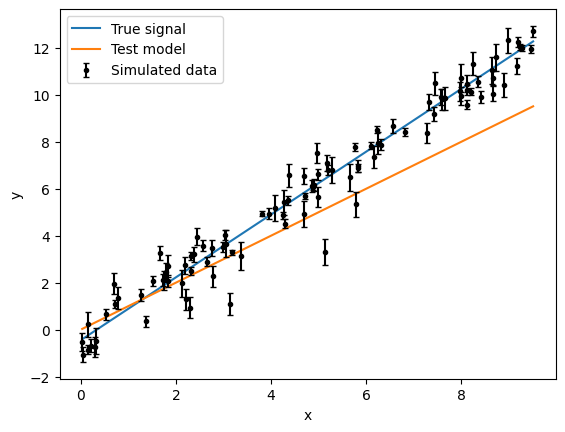

In [5]:
ax = plt.gca()
ax.plot(x, y_true, label="True signal")
ax.plot(x, model.forward(test_point, x), label="Test model")
ax.errorbar(x, y, yerr=yerr, fmt="k.", capsize=2, label="Simulated data")
ax.set_ylabel("y")
ax.set_xlabel("x")
plt.legend()
plt.show()

## Prior checks

First, we can do a prior check.
We will look at the joint prior on parameters to make sure that we did not make any mistake in our specification.

**Note**: We use [corner](https://corner.readthedocs.io/en/latest/) to display the posterior.
You will need to install it along with [arviz](https://python.arviz.org/en/stable/) to display the prior and posterior distributions.

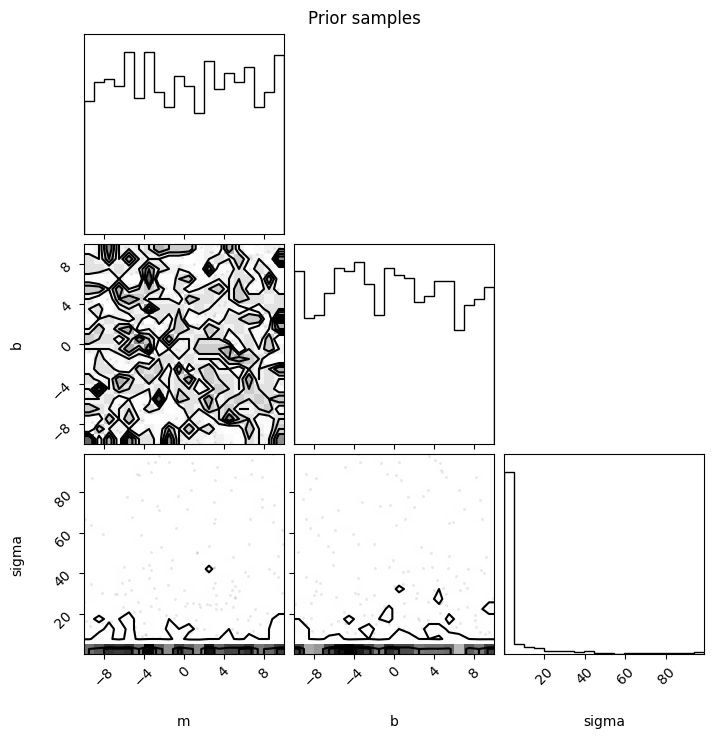

In [6]:
import corner

n_prior = 1000
prior_samples = model.get_prior_samples(n_prior)

fig = corner.corner(prior_samples)
fig.suptitle("Prior samples")
plt.show()

We can also look at forward model predictions for prior samples.
This gives a good idea of whether the parameter space covers all the data and yields reasonable models.

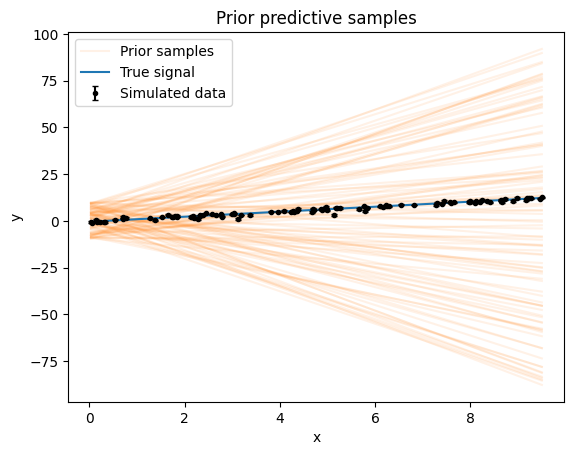

In [7]:
n_pred = 100
ypreds = model.get_prior_pred(n_pred, x)
ax = plt.gca()
for i, ypred in enumerate(ypreds):
    ax.plot(x, ypred, "C1-", label="Prior samples" if i == 0 else None, alpha=0.1)
ax.plot(x, y_true, label="True signal")
ax.errorbar(x, y, yerr=yerr, fmt="k.", capsize=2, label="Simulated data")
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_title("Prior predictive samples")
plt.legend()
plt.show()

## Posterior sampling

To sample the posterior distribution, let us use the [`zeus-mcmc`](https://zeus-mcmc.readthedocs.io/) package.
Feel free to replace this with your favorite MCMC or nested sampling library.

In [8]:
import zeus

nwalkers = 100
nsteps = 1000
ndim = len(model.keys())
start = np.array([0.0, 0.0, 10.0]) + rng.standard_normal(size=(nwalkers, ndim))
sampler = zeus.EnsembleSampler(nwalkers, ndim, model.log_prob, args=(x, y, yerr))
sampler.run_mcmc(start, nsteps)

Initialising ensemble of 100 walkers...
Sampling progress : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:54<00:00,  5.73it/s]


## Posterior distribution and predictions

Just like we did for the prior, we can now visualize the posterior and some predictive samples drawn from the posterior.

First, let us look at the chains to make sure they are well-behaved.
It is quite common to show the chains in plot like the one below, and they are somewhat cumbersone to code.
For that reason, `simpple` comes with a `chainplot` utility function.

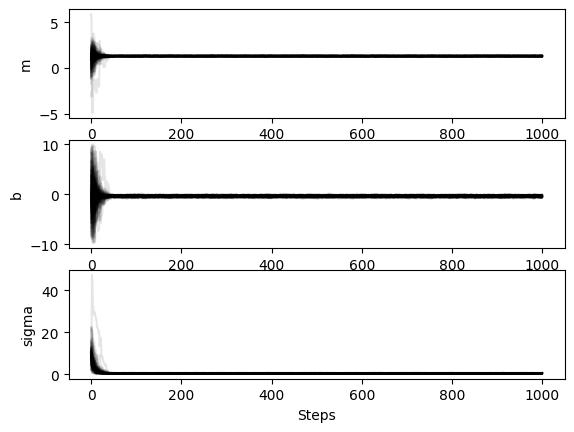

In [9]:
from simpple.plot import chainplot

chains = sampler.get_chain()
chainplot(chains, labels=model.keys())
plt.show()

200 seems like a safe warm-up in this case!

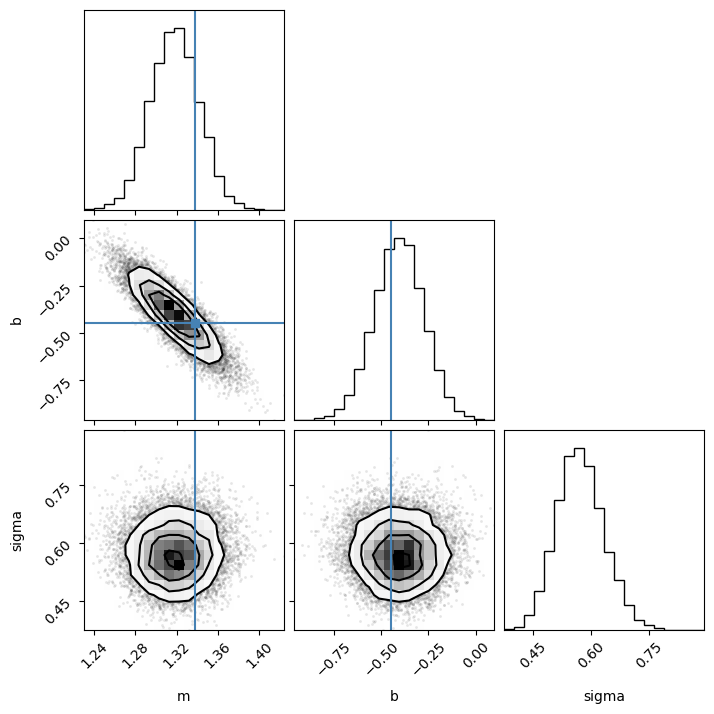

In [10]:
flat_chains = sampler.get_chain(discard=200, flat=True, thin=5)
corner.corner(
    flat_chains,
    labels=model.keys(),
    truths=list(truths.values()),
)
plt.show()

To sample the posterior, we need to use the `get_posterior_pred()` function.
It takes both the chains and a number of samples for arguments.
`n_pred` samples will be drawn from the chain at random.

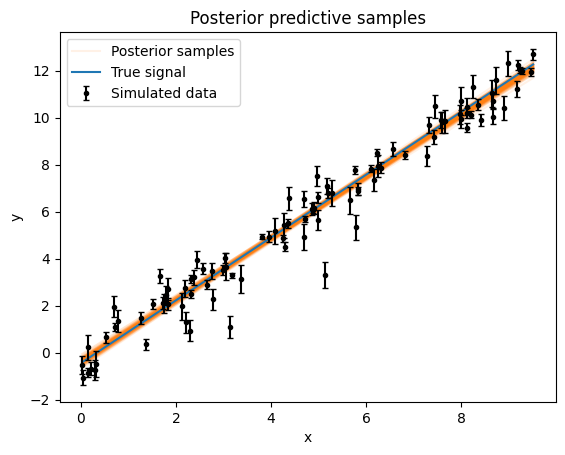

In [11]:
n_pred = 100
ypreds = model.get_posterior_pred(flat_chains.T, n_pred, x)
ax = plt.gca()
for i, ypred in enumerate(ypreds):
    ax.plot(x, ypred, "C1-", label="Posterior samples" if i == 0 else None, alpha=0.1)
ax.plot(x, y_true, label="True signal")
ax.errorbar(x, y, yerr=yerr, fmt="k.", capsize=2, label="Simulated data")
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_title("Posterior predictive samples")
plt.legend()
plt.show()

And we are done!

This notebook shows all the basic steps to perform Bayesian inference with `simpple`.
The main things that will change in real usage are the forward model and prior definitions (and of course the data).
Everything else from this notebook should be re-usable almost as-is.